In [148]:
import torch, clip
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas as pd

In [149]:
# Selección del dispositivo y carga del modelo CLIP

import os 

def setConfig():
    """
    Configura el dispositivo para PyTorch y spaCy según la disponibilidad de hardware.
    Devuelve el dispositivo configurado.
    """
    if torch.backends.mps.is_available():
        # Usar MPS (Metal Performance Shaders) en macOS
        device = torch.device("mps")
    elif torch.cuda.is_available():
        # Usar CUDA (GPU NVIDIA) si está disponible
        device = torch.device("cuda")
        os.environ["CUDA_VISIBLE_DEVICES"] = "0"
        os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"
        os.environ["TOKENIZERS_PARALLELISM"] = "false"
        os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
    else:
        # Usar CPU como fallback
        device = torch.device("cpu")
    try:
        torch.ones(1, device=device)
    except Exception as e:
        print("Error:", e)
        raise e
    
    return device

device = setConfig()

model, preprocess = clip.load("ViT-B/32", device=device)

## Main

In [150]:
target = "pornstar"
words = ["key", "heart", "gold", "ice cream", "France", "battery", "spy", "wall", "collision", "force", "ace", "embassy", "water", "lawyer", "Malta", "Loch Ness", "Italy", "penguin", "board", "magic", "eagle", "subway", "America", "series", "belt"]
target_token = clip.tokenize([target]).to(device)
text_tokens = clip.tokenize(words).to(device)

Similaridades con la palabra objetivo: pornstar
         word  similarity
22    America    0.854980
1       heart    0.825195
9       force    0.824707
10        ace    0.820801
6         spy    0.819824
12      water    0.809082
2        gold    0.807617
19      magic    0.805664
13     lawyer    0.798340
7        wall    0.797363
23     series    0.794434
18      board    0.788574
8   collision    0.784180
11    embassy    0.778809
4      France    0.778809
16      Italy    0.772949
20      eagle    0.770020
0         key    0.767090
24       belt    0.757812
17    penguin    0.757324
3   ice cream    0.752930
14      Malta    0.744141
21     subway    0.714844
15  Loch Ness    0.653320
5     battery    0.625000


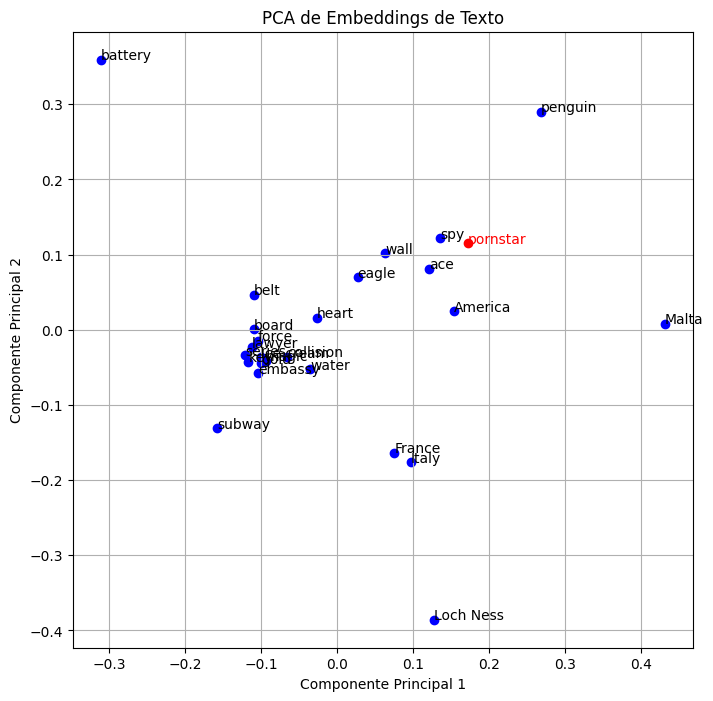

In [151]:
with torch.no_grad():
    text_embeddings = model.encode_text(text_tokens)

text_embeddings /= text_embeddings.norm(dim=-1, keepdim=True)
target_embedding = model.encode_text(target_token)
target_embedding /= target_embedding.norm(dim=-1, keepdim=True)

target_similarity = (text_embeddings @ target_embedding.T).squeeze().detach().cpu().numpy()
df = pd.DataFrame({'word': words, 'similarity': target_similarity})

print(f"Similaridades con la palabra objetivo: {target}")
# order by similarity
df = df.sort_values(by='similarity', ascending=False)
print(df)

pca = PCA(n_components=2)
all_ = torch.cat([text_embeddings, target_embedding], dim=0)
text_embeddings_2d = pca.fit_transform(all_.cpu().detach().numpy())
plt.figure(figsize=(8, 8))
plt.scatter(text_embeddings_2d[:-1, 0], text_embeddings_2d[:-1, 1], color='blue')
plt.scatter(text_embeddings_2d[-1, 0], text_embeddings_2d[-1, 1], color='red')  # Target en rojo
for i, word in enumerate(words):
    plt.annotate(word, (text_embeddings_2d[i, 0], text_embeddings_2d[i, 1]))
plt.annotate(target, (text_embeddings_2d[-1, 0], text_embeddings_2d[-1, 1]), color='red')
plt.title('PCA de Embeddings de Texto')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.grid()
plt.show()